In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 12,
                     'axes.labelsize': 18,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 10,
                     'ytick.labelsize' : 10,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

### Concentration profile in which taxis is performed

(can be a chemical profile, temperature profile, etc)

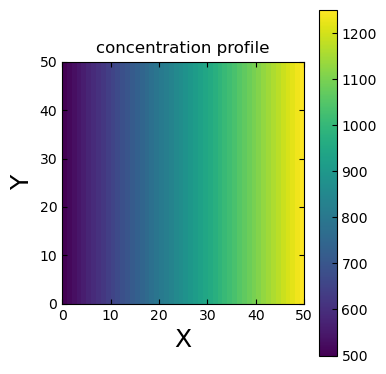

In [3]:
#Domain (2D)
L = 50
X,Y = np.meshgrid(np.linspace(0,L,L),np.linspace(0,L,L))

#define simple linear gradient along x
c0 = 500
C_profile = c0 + 15*X

#Visualise the gradient
plt.figure(figsize=(4,4))
plt.imshow(C_profile,extent=[0,L,0,L])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('concentration profile')
plt.colorbar()
plt.tight_layout()

### Run duration distribution

Text(0.5, 0, '$\\lambda^{-1}$ [sec]')

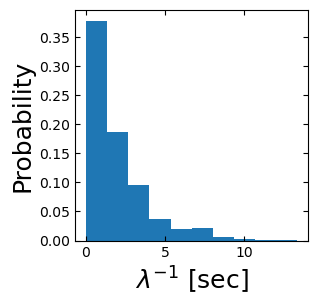

In [4]:
## Run duration distribution
run_duration_dist = np.random.exponential(scale=2,size=1000)
plt.figure(figsize=(3,3))
plt.hist(run_duration_dist,density=True);
plt.ylabel('Probability')
plt.xlabel('$\lambda^{-1}$ [sec]')

### Turn angle distribution

Text(0.5, 0, '$\\Theta$ [deg]')

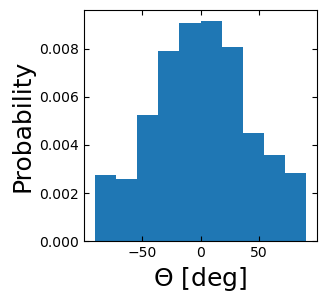

In [5]:
#samples = np.random.uniform(-90,90,size=1000)
# Generate random samples from a normal distribution and clip
theta_dist = np.random.normal(0, scale=45, size=1000)
theta_dist = np.clip(theta_dist, -90, 90)
plt.figure(figsize=(3,3))
plt.hist(theta_dist,density=True);
plt.ylabel('Probability')
plt.xlabel('$\Theta$ [deg]')

In [6]:
class Bacteria:

    # class variables
    f = 2.2e-19 # this is k_B T/(6 pi eta) in m^3/s
    dt = 0.02
    bias = int(0.1/dt) #reduces run duration by 0.1 seconds everytime it goes the wrong way

    def __init__(self, R, v0, alpha, x0, y0, theta0):
        ## Initialisation
        self.R = R
        self.x = [x0]
        self.y = [y0]
        self.prop_angle = [theta0] 
        #increment number of bacteria every time a particle object is initialised (this property accessible by class)
        self.D = Bacteria.f/self.R
        self.v0 = v0 #propulsion velocity
        self.alpha = alpha #tumble rate 
        self.countdown_time = 1/self.alpha #run duration in secs
        self.countdown = int(self.countdown_time/Bacteria.dt) #number of timesteps before tumble (when no gradient in present)

    def get_concentration_profile(x,y):
        # Linear concentration profile as shown in previous section
        #print('called inside')
        return(500 + 15*x*1e6) #factor of 1e6 to compensate for the um units of x

    def tumble(theta):
        #return orientation after tumble event
        dtheta = np.random.normal(0, scale=45)
        dtheta = np.clip(dtheta, -90, 90)
        return(theta + dtheta)
        #return(theta + np.random.normal(0,50)) #turn angle has mean of 0 and std 50
        

    def update(self):
        
        # get last angle
        theta = self.prop_angle[-1]
        #tumble and return the new angle
        theta_new = Bacteria.tumble(theta)

        #Tumbles occur at a constant rate and are uncorrelated in time, following a Poisson distribution
        #Run durations thus follow an exponential distribution 
        run_duration = np.random.exponential(scale=self.countdown_time)
        #Reset countdown for the run
        self.countdown = int(run_duration/self.dt) #in steps
        
        ### Run begins
        while self.countdown > 0:
            #execute until the run is not over 
            #theta does not change until end of run
            new_concentration = Bacteria.get_concentration_profile(self.x[-1],self.y[-1])
            #print(self.x,self.y)

            ## compare the concentration value sensed to the recent past
            # the bacteria has a short biochemical memeory that allows it to remember the most recent information
            # This memory is critical to their navigation (taxis), which wouldn't work otherwise 
            # The movement of bacteria is a random walk with memory
            try:
                #old_concentration = Bacteria.get_concentration_profile(self.x[-2],self.y[-2])
                ##get past 3 concentration values that were sensed and average
                concentration_recent_history = np.array([Bacteria.get_concentration_profile(self.x[-2],self.y[-2]),
                Bacteria.get_concentration_profile(self.x[-3],self.y[-3]),Bacteria.get_concentration_profile(self.x[-4],self.y[-4])])
                concentration_recent_history_avg = np.mean(concentration_recent_history)
            except IndexError: 
                #case where it is still in 1st iteration of loop i.e. very beginning of the run where no history exists to compare
                concentration_recent_history_avg = new_concentration
            
            #compared concentrations and reduced the run time by a defined factor if going in the wrong way
            if (concentration_recent_history_avg - new_concentration) > 0.5:
                #if the previous concentration was better, make the run shorter
                self.countdown = self.countdown - self.bias
    
            #self translational diffusion
            displacement_x = np.random.normal(0.0, np.sqrt(2*self.D*self.dt))*random.choice([1, -1])
            displacement_y = np.random.normal(0.0, np.sqrt(2*self.D*self.dt))*random.choice([1, -1])
            
            #add the self propulsion term here to the displacement. The displacement is projected onto the propulsion direction 
            displacement_x = displacement_x + self.dt*self.v0*np.cos(theta_new)
            displacement_y = displacement_y + self.dt*self.v0*np.sin(theta_new)

            self.countdown = self.countdown - 1

            # Add position at the end of the run to history of positions
            self.x.append(self.x[-1]+displacement_x)
            self.y.append(self.y[-1]+displacement_y)
            self.prop_angle.append(theta_new)

        ### Run ends
        

        #return new position
        return(self.x[-1],self.y[-1])

In [7]:
# Define the initial configuration

#Number of bacteria
N = 50

#Domain (2D)
#L = 50 #in um

b=[]
for _ in range(N):
    size = 2e-6 #1um sphere for now
    v0 = 20e-6
    alpha = 0.5 #tumble rate
    #randomise the initial positions of the bacteria
    #the bacteria spawn in an area between 100 and 200 um in X and Y
    initial_position_x = np.random.randint(100,200)*1e-6
    initial_position_y = np.random.randint(100,200)*1e-6
    #initial propulsion directions
    initial_thetas = np.random.randint(0,2*np.pi)
    b.append(Bacteria(size,v0,alpha,
                      initial_position_x,initial_position_y,initial_thetas))

In [8]:
def compute():
    for _ in tqdm(range(40)):
        for i in range(N):
            b[i].update()

In [9]:
#perform the computation
compute()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.96it/s]


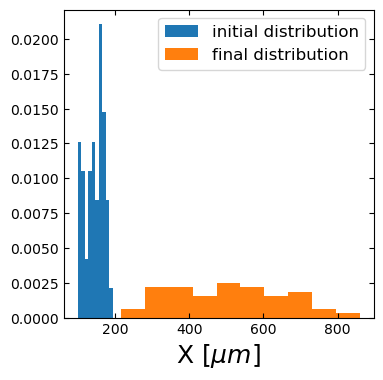

In [10]:
## Plot final distribution of bacteria
scale = 1e6
plt.figure(figsize=(4,4))
#plt.hist2d(np.array([b_obj.x[-1] for b_obj in b])*scale, np.array([b_obj.y[-1] for b_obj in b])*scale,bins=20);
plt.hist(np.array([b_obj.x[0] for b_obj in b])*scale,bins=10, density=True, label='initial distribution');
plt.hist(np.array([b_obj.x[-1] for b_obj in b])*scale,bins=10, density=True, label='final distribution');
plt.xlabel('X [$\mu m$]')
plt.legend()

## Show trajectory animation

In [11]:
current_positions = np.zeros((N,2))
prop_angle = np.zeros((N,1))
for i in range(N):
    current_positions[i,:] = b[i].x[0],b[i].y[0]
    prop_angle = b[i].prop_angle[0]

#Intialise the animation
fig, ax= plt.subplots(figsize=(8,5.3))
#ax.set_aspect('equal', adjustable='box')
# Set the background color to black
ax.set_facecolor('black') 
q_plot = ax.quiver(current_positions[:,0], current_positions[:,1], np.cos(prop_angle), np.sin(prop_angle),color='white'
                  ,scale=30,width=1e-2,headwidth=0,headlength=0,headaxislength=0)
ax.set_xlim(50*1e-6, 500*1e-6)
ax.set_ylim(0, 300*1e-6)
ax.set_xticks(np.array([50,150,250,350,450])*1e-6)
ax.set_yticks(np.array([0,100,200,300])*1e-6)
ax.ticklabel_format(style='sci', axis='both', scilimits =(0,0))
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.tight_layout()
plt.close()



def animate_2(frame):
    progress_bar.update(1)
    current_positions = np.zeros((N,2))
    prop_angle = np.zeros((N,1))
    # Get the positions at the current time step
    for i in range(N):
        current_positions[i,:] = b[i].x[frame],b[i].y[frame]
        prop_angle[i] = b[i].prop_angle[frame]

    
    # Set the new vector data to the quiver plot
    q_plot.set_offsets(current_positions)
    q_plot.set_UVC(np.cos(prop_angle), np.sin(prop_angle))
    return q_plot,

In [12]:
total_steps_to_animate = 800
#tqdm progress bar
progress_bar = tqdm(total=total_steps_to_animate, position=0, desc="Progress")
anim = FuncAnimation(fig, animate_2, frames=np.arange(1,total_steps_to_animate), blit=True, interval=20)
HTML(anim.to_html5_video())

Progress: 100%|██████████████████████████████████████████████████████████████████████| 800/800 [00:34<00:00, 23.07it/s]

Progress: 802it [00:47, 23.07it/s]                                                                                     

In [15]:
from matplotlib.animation import FFMpegWriter

In [16]:
# saving to m4 using ffmpeg writer 
writervideo =FFMpegWriter(fps=60) 
anim.save('Bacteria_animation.mp4', writer=writervideo) 

Progress: 1602it [06:37, 22.56it/s]